In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [2]:
datadir = 'input/'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [3]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [4]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [5]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [6]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9222956879900151005,548,18,21594.0,NaN
1,-9222956879900151005,1096,18,21594.0,NaN
2,-9222956879900151005,1248,26,21594.0,NaN
3,-9222956879900151005,1545,12,21594.0,NaN
4,-9222956879900151005,1664,18,21594.0,NaN


In [7]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 19237), test shape (112071, 19237)


In [8]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 21035), test shape (112071, 21035)


In [9]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [32]:
def score(clf, random_state = 667):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
        #return log_loss(yte, pred[itest, :])
    #print('')
    print("{:.5f}".format(log_loss(y, pred)), end=' ')
    return log_loss(y, pred)

[  1.00000000e-05   3.59381366e-05   1.29154967e-04   4.64158883e-04
   1.66810054e-03   5.99484250e-03   2.15443469e-02   7.74263683e-02
   2.78255940e-01   1.00000000e+00]
2.47809 2.46488 2.43735 2.39617 2.34918 2.31107 2.29053 2.29082 2.32136 2.40271 

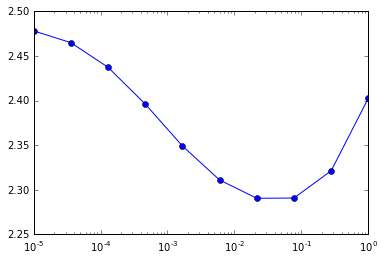

In [13]:
Cs = np.logspace(-5,0,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, n_jobs=-1)))
plt.semilogx(Cs, res,'-o');

[ 0.01        0.03111111  0.05222222  0.07333333  0.09444444  0.11555556
  0.13666667  0.15777778  0.17888889  0.2       ]
2.30058 2.28826 2.28816 2.29030 2.29319 2.29638 2.29968 2.30302 2.30634 2.30962 

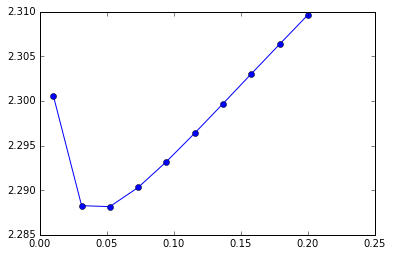

In [14]:
Cs = np.linspace(0.01,0.2,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.plot(Cs, res,'-o');

[ 0.03        0.03444444  0.03888889  0.04333333  0.04777778  0.05222222
  0.05666667  0.06111111  0.06555556  0.07      ]
2.28666 2.28637 2.28635 2.28654 2.28688 2.28733 2.28787 2.28847 2.28913 2.28983 

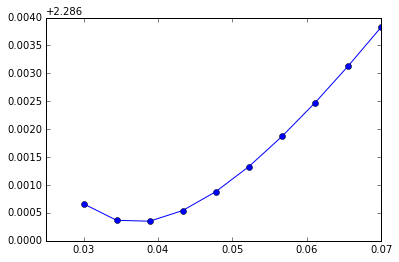

In [16]:
Cs = np.linspace(0.03,0.07,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.plot(Cs, res,'-o');

[ 0.03        0.03222222  0.03444444  0.03666667  0.03888889  0.04111111
  0.04333333  0.04555556  0.04777778  0.05      ]
2.28227 2.28193 2.28168 2.28150 2.28138 2.28132 2.28131 2.28133 2.28140 2.28149 

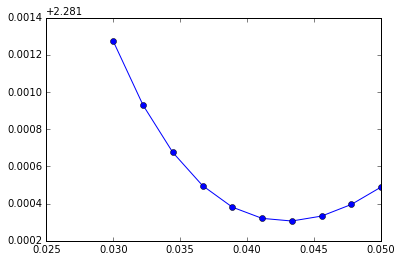

In [18]:
Cs = np.linspace(0.03,0.05,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.plot(Cs, res,'-o');

[ 0.038  0.039  0.04   0.041  0.042]
2.28129 2.28139 2.28151 2.28164 2.28177 

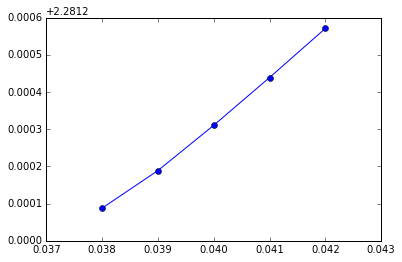

In [21]:
Cs = np.linspace(0.038,0.042,5)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C=C, multi_class='multinomial',solver='lbfgs')))
plt.plot(Cs, res,'-o');

[ 0.034  0.035  0.036  0.037  0.038]
2.27581 2.27581 2.27582 2.27585 2.27589 

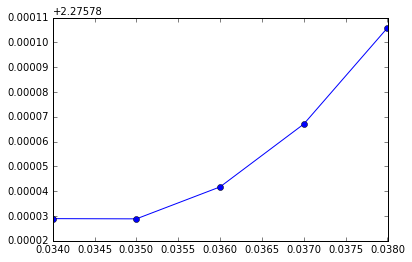

In [35]:
Cs = np.linspace(0.034,0.038,5)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C=C, multi_class='multinomial',solver='lbfgs')))
plt.plot(Cs, res,'-o');

In [36]:
score(LogisticRegression(C=0.034, multi_class='multinomial',solver='lbfgs'))

2.27581 

2.2758089377560471